In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
from datetime import date
from statistics import mean
from math import sqrt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import neural_network
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 144, "display.max_columns", 100)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [2]:
# Common function definitions
def graphRes(act, pred):
    ax = plt.gca()
    for pos in positions:
        ax.scatter(act[pos],pred[pos], label=f'{pos} ({r2_score(act[pos], pred[pos]).round(2)})')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(labels)
    ax.plot(act['QB'],act['QB'],color='black') # y==x reference line
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

def printStats(y_dev, y_pred):
    graphRes(y_dev, y_pred)

    stats = pd.DataFrame(index = [positions], columns = ['MAE','RMSE','R^2'])
    for pos in positions:
        stats.loc[pos,'MAE'] = mean_absolute_error(y_dev[pos], y_pred[pos]).round(1)
        stats.loc[pos,'RMSE'] = round(math.sqrt(mean_squared_error(y_dev[pos], y_pred[pos])),1)
        stats.loc[pos,'R^2'] = r2_score(y_dev[pos], y_pred[pos]).round(2)
    
    display(stats)
    
def cvGrid(params, res):
    names = ['param_' + x for x in list(params.keys())]
    return pd.DataFrame(res)[names+['mean_test_score','std_test_score','rank_test_score','mean_fit_time','mean_score_time','std_fit_time','std_score_time']].sort_values(names)


In [3]:
# Partition training, dev, and test data
positions = ['QB','RB','WR','TE']
X_train, X_dev, X_test = {}, {}, {}
y_train, y_dev, y_test = {}, {}, {}
data = {}
for pos in positions:
    Xy = pd.read_csv(f'../{pos}.csv').dropna(subset=['fanPts'])
    data[pos] = Xy
    X = Xy.loc[:,Xy.columns.str.contains('-\d+') | Xy.columns.str.match('fanPts')] \
        .drop('fanPts',axis=1) \
        .fillna(0)
    y = Xy.fanPts
    
    # Split
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.3, random_state=0)
    X_dev_raw, X_test_raw, y_dev_raw, y_test_raw = train_test_split(X_test_raw, y_test_raw, test_size=0.5, random_state=0)
    
    # Scale X data
    ss = preprocessing.StandardScaler()
    X_train[pos] = pd.DataFrame(ss.fit_transform(X_train_raw), columns=X_train_raw.columns)
    X_dev[pos] = pd.DataFrame(ss.fit_transform(X_dev_raw), columns=X_dev_raw.columns)
    X_test[pos] = pd.DataFrame(ss.fit_transform(X_test_raw), columns=X_test_raw.columns)
    
    # Leave y data in original units
    y_train[pos] = y_train_raw
    y_dev[pos] = y_dev_raw
    y_test[pos] = y_test_raw

### Multi-layer Perceptron Regression

#### Base model

QB: 3 layers, 2069 iterations


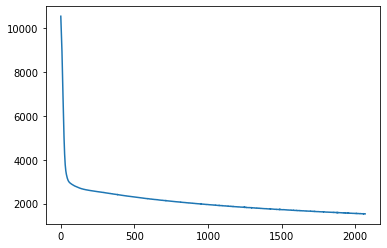

RB: 3 layers, 761 iterations


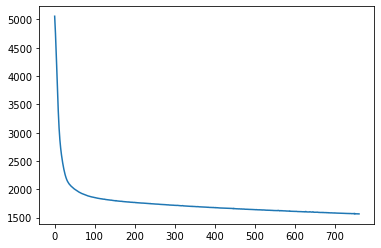

WR: 3 layers, 1419 iterations


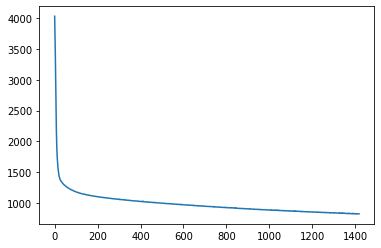

TE: 3 layers, 1345 iterations


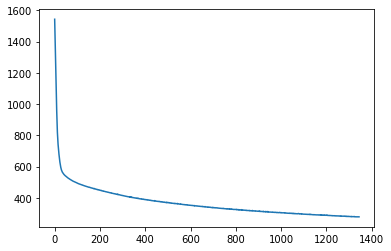

,MAE,RMSE,R^2
QB,64.700,85.300,0.380
RB,44.900,62.600,0.410
WR,39.400,58.600,0.350
TE,23.800,34.400,0.320


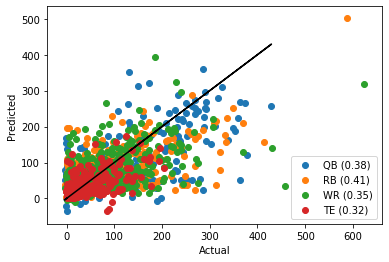

In [4]:
y_pred = {}
for pos in positions:
    m = neural_network.MLPRegressor(max_iter=2500)
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    print(f'{pos}: {m.n_layers_} layers, {m.n_iter_} iterations')
    plt.plot(m.loss_curve_)
    plt.show()

printStats(y_dev, y_pred)

#### GridSearchCV

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 16.4min finished


QB: 3 layers, 3596 iterations


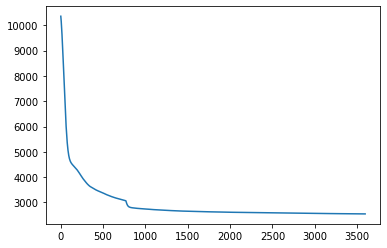

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 16.7min finished


RB: 3 layers, 2365 iterations


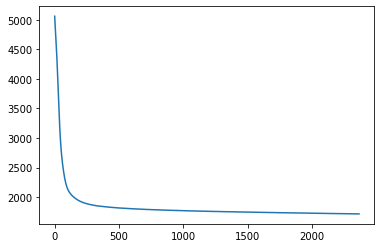

Fitting 3 folds for each of 132 candidates, totalling 396 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 396 out of 396 | elapsed: 27.3min finished


WR: 3 layers, 1244 iterations


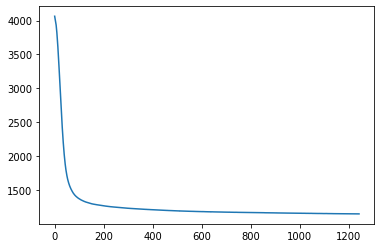

Fitting 3 folds for each of 132 candidates, totalling 396 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 396 out of 396 | elapsed: 12.4min finished


TE: 3 layers, 3366 iterations


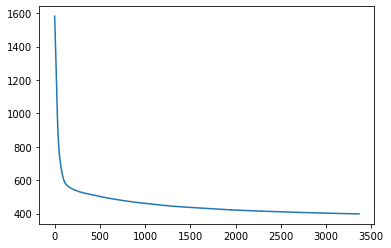

QB: {'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': 3, 'solver': 'adam'}
RB: {'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': 9, 'solver': 'adam'}
WR: {'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': 6, 'solver': 'adam'}
TE: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 6, 'solver': 'adam'}


,MAE,RMSE,R^2
QB,62.400,81.000,0.440
RB,44.200,61.900,0.420
WR,38.300,56.600,0.390
TE,22.500,32.600,0.390


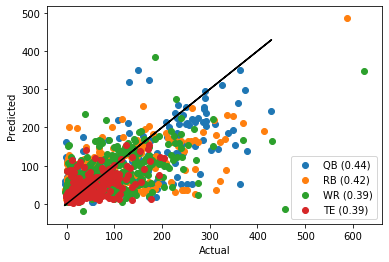

In [8]:
y_pred = {}
bestParams = {}
maxIter = 5000
for pos in positions:
    inputNodes = len(X_train[pos].columns)
    outputNodes = len(y_train[pos].shape) if y_train[pos].shape == 2 else 1
    nSamples = len(X_train[pos])

    sizes = [
        mean([inputNodes,outputNodes]),
        (2/3)*inputNodes + outputNodes,
        sqrt(inputNodes*outputNodes),
        inputNodes*2-1
    ] + [nSamples/(x*(inputNodes+outputNodes)) for x in range(2,11)]# + [x for x in range(2,21)]

    params={
        'activation':['relu'],
        'solver':['lbfgs','adam'],
        'hidden_layer_sizes': list(set(map(int, sizes))),
        'alpha':[10**x for x in range(-5,1)],
    }

    grid = GridSearchCV(
        neural_network.MLPRegressor(warm_start=False,random_state=0,max_iter=maxIter),
        params,
        n_jobs = -1,
        verbose = 1,
        cv = 3
    ).fit(X_train[pos],y_train[pos])

    bestParams[pos] = grid.best_params_
    
    cvGrid(params, grid.cv_results_).to_csv(f'nn{pos}.csv')
    
    m = neural_network.MLPRegressor(**bestParams[pos],max_iter=maxIter)
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    print(f'{pos}: {m.n_layers_} layers, {m.n_iter_} iterations')
    plt.plot(m.loss_curve_)
    plt.show()
    
for pos in positions:
    print(f'{pos}: {bestParams[pos]}')
printStats(y_dev,y_pred)